In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import math
import os
import pandas as pd
import numpy as np
from tensorflow.python.framework import ops
import matplotlib
plt.ion()
from random import randint
import time
from ipywidgets import FloatProgress
from IPython.display import display, clear_output
ops.reset_default_graph()
print("OK")

OK


In [4]:
inputdata2 = pd.read_csv('Datasets_in_JWA_2峰.csv', encoding='shift_jis',dtype = 'float')
a_df2 = inputdata2.values
print(np.shape(a_df2))

(40000, 910)


In [2]:
"""csvファイルの読み込み"""
inputdata1 = pd.read_csv('Datasets_in_JWA_1峰.csv', encoding='shift_jis',dtype = 'float')
a_df1 = inputdata1.values
print(np.shape(a_df1))

(30000, 910)


In [6]:
a_df=np.append(a_df1,a_df2,axis=0)
#a_df = b_df[np.array(b_df[:,1141:1142]>0.5).flatten()][:]
print(np.shape(a_df))

(70000, 910)


In [7]:
input_shape_rows   =25  #入力データの行
input_shape_columns=36
output_shape= 10       #出力の

"""入力データと出力データを分けて読み込む"""
#x_vals = np.array([x[0:816] for x in a_df])
#y_vals = np.array([x[816:821] for x in a_df])
xdata = np.array([np.reshape(x[0:input_shape_rows*input_shape_columns],(input_shape_rows,input_shape_columns)) for x in a_df])
ydata  = np.array([x[input_shape_rows*input_shape_columns:input_shape_rows*input_shape_columns+output_shape] for x in a_df])
print(input_shape_columns)

36


In [8]:
"""結果を再現可能にするためのランダムシードを作成"""
seed = 10
np.random.seed(seed)
tf.set_random_seed(seed)
print("OK")

OK


In [9]:
"""正規化の定義"""
def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m-col_min) / (col_max-col_min) 

"""データの最大値と最小値を保存"""
col_max0 = ydata.max(axis=0)
col_min0 = ydata.min(axis=0) 

"""正規化の実行"""
#x_vals0 = np.nan_to_num(normalize_cols(x_vals))   #入力の正規化は不要
ydata_0 = np.nan_to_num(normalize_cols(ydata))

"""訓練データとテストデータを8：2に分割するためのインデックスを作成"""
train_indices = np.random.choice(len(xdata), round(len(xdata)*0.8), replace=False)  #訓練データに使うindex
test_indices  = np.array(list(set(range(len(xdata))) - set(train_indices)))         #テストデータに使うindex

"""入力データを訓練とテストにわけた"""
train_xdata   = xdata[train_indices]    #入力データの訓練集合
test_xdata    = xdata[test_indices]     #入力データのテスト集合

"""出力データを訓練とテストにわけた"""
train_ydata   = ydata_0[train_indices]  #出力データの訓練集合(正規化済み)
test_ydata    = ydata_0[test_indices]   #出力データのテスト集合(正規化済み)
test_ydata_origin    = ydata[test_indices] #出力データのテスト集合(正解値)
print("OK")

OK


In [10]:
"""ネットワーク構造のパラメータを設定"""
batch_size          = 200                     #一回の学習に使うデータの数
learning_rate       = 0.005
evaluation_size     = 200                    #一回のテストに使うデータの数  #len(test_indices) 
image_height        = train_xdata[0].shape[0]  #行
image_width         = train_xdata[0].shape[1]  #列
target_size         = output_shape
num_channels        = 1                        # greyscale = 1 channel
conv1_features      = 10                        #1回目の畳み込みの枚数
filter_size1        = 3
conv2_features      = 15                       #2回目の畳み込みの枚数
filter_size2        = 3
max_pool_size1      = 2                        #プーリング層
max_pool_size2      = 2                        # プーリング層
fully_connected_size1 = 80                     #全結合層のノード数?
fully_connected_size2 = 50
fully_connected_size3 = 30
print("OK")

OK


In [11]:
"""入力データのサイズの格納庫作成"""
x_input_shape = (batch_size, image_height, image_width,num_channels)
x_input = tf.placeholder(tf.float32, shape=x_input_shape)
"""出力データのサイズと格納庫作成"""
y_target = tf.placeholder(tf.float32, shape=(batch_size,output_shape))   


"""入力データのサイズの格納庫作成"""
test_x_input_shape = (evaluation_size, image_height, image_width,num_channels)
test_x_input = tf.placeholder(tf.float32, shape=test_x_input_shape)
"""出力データのサイズと格納庫作成"""
test_y_target = tf.placeholder(tf.float32, shape=(evaluation_size, output_shape))  


"""テスト用入力データのサイズと格納庫作成""" #評価は、一部のデータに対して行う
eval_x_input_shape = (len(test_xdata), image_height, image_width,num_channels)
eval_x_input = tf.placeholder(tf.float32, shape=eval_x_input_shape)
"""テスト用出力データのサイズと格納庫作成"""
eval_y_target = tf.placeholder(tf.float32, shape=(len(test_xdata),output_shape))
print("OK")

OK


In [12]:
"""ネットワーク構造の決定と準備""" #±2σの切断正規分布からランダムに取り出したテンソルを生成する。stddev: 生成する切断正規分布の標準偏差
"""畳み込み層の重みとバイアスの準備"""
#一枚目の畳み込み[1行,6列,60枚]
conv1_weight = tf.Variable(tf.truncated_normal([ filter_size1, filter_size1,num_channels,  conv1_features], stddev=0.1, dtype=tf.float32))
conv1_bias = tf.Variable(tf.truncated_normal([conv1_features], dtype=tf.float32))
#2枚目の畳み込み[1行,4列,30枚]
conv2_weight = tf.Variable(tf.truncated_normal([filter_size2, filter_size2 , conv1_features, conv2_features],stddev=0.1, dtype=tf.float32))
conv2_bias = tf.Variable(tf.truncated_normal([conv2_features], dtype=tf.float32))

"""全結合層の重みとバイアスを準備"""
resulting_width = int(((image_width-filter_size1+1)/max_pool_size1-filter_size2+1)/max_pool_size2)#// (max_pool_size1 * max_pool_size2)
resulting_height = int(((image_height-filter_size1+1)/max_pool_size1-filter_size2+1)/max_pool_size2)#// (max_pool_size1 * max_pool_size2)
full1_input_size = resulting_width * resulting_height * conv2_features  #全結合層(プーリングマップサイズ*チャネル数)
full1_weight = tf.Variable(tf.truncated_normal([full1_input_size, fully_connected_size1],stddev=0.1, dtype=tf.float32))
full1_bias = tf.Variable(tf.truncated_normal([fully_connected_size1], stddev=0.1,dtype=tf.float32))
full2_weight = tf.Variable(tf.truncated_normal([fully_connected_size1, fully_connected_size2],stddev=0.1, dtype=tf.float32))
full2_bias = tf.Variable(tf.truncated_normal([fully_connected_size2], stddev=0.1, dtype=tf.float32))  #(訓練データ数,出力個数=5)
full3_weight = tf.Variable(tf.truncated_normal([fully_connected_size2,fully_connected_size3],stddev=0.1, dtype=tf.float32))
full3_bias = tf.Variable(tf.truncated_normal([fully_connected_size3], stddev=0.1, dtype=tf.float32))
full4_weight = tf.Variable(tf.truncated_normal([fully_connected_size3, target_size],stddev=0.1, dtype=tf.float32))
full4_bias = tf.Variable(tf.truncated_normal([target_size], stddev=0.1, dtype=tf.float32))
print("OK")

OK


In [13]:
"""畳み込みと全結合を計算する関数作成"""
def my_conv_net(input_data):
    # 1枚目の畳み込み
    conv1 = tf.nn.conv2d(input_data, conv1_weight, strides=[1, 1, 1, 1], padding='VALID')#ゼロパディングを利用する場合はSAMEを指定,否はVALID
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
    max_pool1 = tf.nn.max_pool(relu1, ksize=[1, max_pool_size1, max_pool_size1, 1],strides=[1,max_pool_size1, max_pool_size1, 1], padding='VALID')
    
    # 2枚目の畳み込み　Second Conv-ReLU-MaxPool Layer
    conv2 = tf.nn.conv2d(max_pool1, conv2_weight, strides=[1, 1, 1, 1], padding='VALID')
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_bias))
    max_pool2 = tf.nn.max_pool(relu2, ksize=[1, max_pool_size2, max_pool_size2, 1],strides=[1, max_pool_size2, max_pool_size2, 1], padding='VALID')

    # 全結合層の引き渡すための並び替え Transform Output into a 1xN layer for next fully connected layer
    final_conv_shape = max_pool2.get_shape().as_list()
    final_shape = tf.cast(final_conv_shape[1] * final_conv_shape[2] * final_conv_shape[3], tf.float32) #6120
    flat_output = tf.reshape(max_pool2, [final_conv_shape[0], final_shape])

    # 全結合層
    fully_connected1 = tf.nn.relu(tf.add(tf.matmul(flat_output, full1_weight), full1_bias))
    fully_connected2 = tf.nn.relu(tf.add(tf.matmul(fully_connected1, full2_weight), full2_bias))
    fully_connected3 = tf.nn.sigmoid(tf.add(tf.matmul(fully_connected2, full3_weight), full3_bias))

    final_model_output = tf.add(tf.matmul(fully_connected3, full4_weight), full4_bias)
    
    return final_model_output
print("OK")

OK


In [14]:
"""畳み込みと全結合層の結果を受け取る"""
model_output      = my_conv_net(     x_input)
test_model_output = my_conv_net(test_x_input)
eval_model_output = my_conv_net(eval_x_input) #テスト用

"""全結合層からの出力を出力層の活性化関数にいれる"""
prediction      = tf.nn.relu(     model_output)          #ReLU関数を使用した
test_prediction = tf.nn.relu(test_model_output)
eval_prediction = tf.nn.relu(eval_model_output)
print("OK")

OK


In [15]:
"""損失を計算"""
loss      = tf.reduce_mean(tf.abs(     prediction - tf.cast(     y_target, tf.float32)))
test_loss = tf.reduce_mean(tf.abs(test_prediction - tf.cast(test_y_target, tf.float32)))
print("OK")

OK


In [16]:
"""勾配降下法と最適化"""
my_optimizer =tf.train.AdamOptimizer(0.00050)#tf.train.MomentumOptimizer(learning_rate, 0.9)# tf.train.AdamOptimizer(0.005)#
train_step = my_optimizer.minimize(loss)
print("OK")

OK


In [17]:
"""精度"""
def get_accuracy(logits, targets):
    batch_predictions = np.argmax(logits, axis=1)
    num_correct = np.sum(np.equal(batch_predictions, targets))
    return (100. * num_correct/batch_predictions.shape[0])
print("OK")

OK


In [18]:
"""推定結果や精度を保存するリスト準備"""
list_train_loss = []
list_test_loss=[]
print("OK")

OK


In [19]:
sess=tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
print("OK")

OK


Generation: 50000. Loss = 0.08901308 ,  Test Loss = 0.09366199


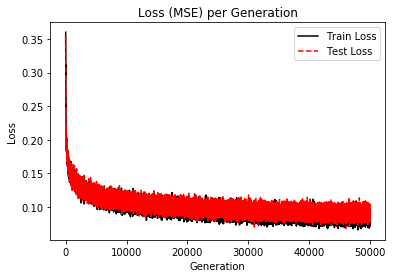

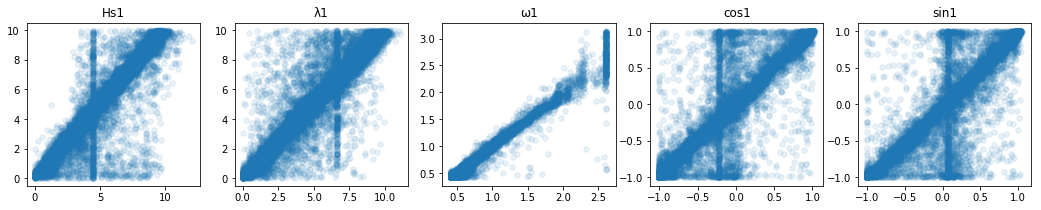

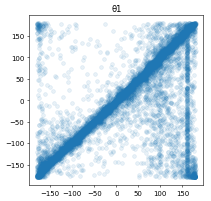

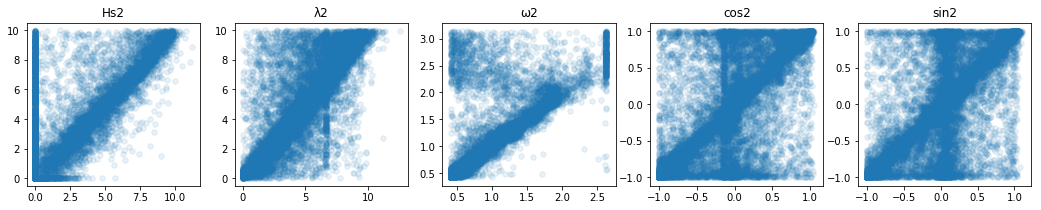

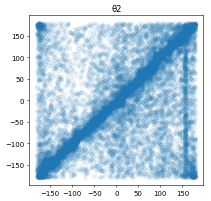

In [20]:
"""描画するグラフの設定"""
siz = 10
#dat = np.zeros((siz, siz))
fig, (axe_H,axe_lambda, axe_w,axe_cos,axe_sin) = plt.subplots(ncols=5, figsize=(15,5))
fig2, (axe_H2,axe_lambda2, axe_w2,axe_cos2,axe_sin2) = plt.subplots(ncols=5, figsize=(15,5))

"""計算始める"""
print("start")
generations         = 50000  #計算回数
eval_every          = 100    #100世代ごとにプロット
for i in range(generations):
    """訓練にデータの作成"""
    rand_index = np.random.choice(len(train_xdata), size=batch_size)
    rand_x = train_xdata[rand_index]      #入力データの訓練集合からバッチサイズ分取り出す
    rand_x = np.expand_dims(rand_x, 3)
    rand_y = train_ydata[rand_index]
    train_dict = {x_input: rand_x, y_target: rand_y}
    sess.run(train_step, feed_dict=train_dict)
    temp_train_loss,temp_train_preds = sess.run( [loss,prediction], feed_dict=train_dict)
    
    """テストデータで計算"""
    test_index = np.random.choice(len(test_xdata), size=evaluation_size)
    test_x = test_xdata[test_index]
    test_x = np.expand_dims(test_x, 3)
    test_y = test_ydata[test_index]
    test_dict = {test_x_input: test_x, test_y_target: test_y}
    temp_test_loss= sess.run(test_loss, feed_dict=test_dict)
    

    """訓練データとテストデータそれぞれの誤差を格納"""
    list_train_loss.append(temp_train_loss)
    list_test_loss.append(temp_test_loss)
    
    if (i+1) % eval_every == 0:
        """テストデータで計算"""
        eval_x = test_xdata
        eval_x = np.expand_dims(eval_x, 3)
        eval_y = test_ydata
        eval_dict = {eval_x_input: eval_x, eval_y_target: eval_y}
        eval_preds = sess.run(eval_prediction, feed_dict=eval_dict)
    
        clear_output(wait = True)
        plt.close()

        print('Generation: ' + str(i+1) + '. Loss = ' + str(temp_train_loss)+" ,  Test Loss = "+str(temp_test_loss))
        #グラフをプロット
        plt.plot(list_train_loss, 'k-', label='Train Loss')
        plt.plot(list_test_loss, 'r--', label='Test Loss')
        plt.title('Loss (MSE) per Generation')
        #plt.ylim(0,0.30)
        plt.legend(loc='upper right')
        plt.xlabel('Generation')
        plt.ylabel('Loss')
        plt.show()
        
        axe_H.scatter(eval_preds[:,0:1]*(col_max0[0:1] - col_min0[0:1]) + col_min0[0:1],test_ydata_origin[:,0:1],s=30, alpha=0.1)#*(col_max0[0:1] - col_min0[0:1]) + col_min0[0:1]
        axe_H.set_title('Hs1')
        axe_w.scatter(eval_preds[:,4:5]*(col_max0[4:5] - col_min0[4:5]) + col_min0[4:5],test_ydata_origin[:,4:5],s=30, alpha=0.1)#*(col_max0[4:5] - col_min0[4:5]) + col_min0[4:5]
        axe_w.set_title('ω1')
        axe_cos.scatter(eval_preds[:,1:2]*(col_max0[1:2] - col_min0[1:2]) + col_min0[1:2],test_ydata_origin[:,1:2],s=30, alpha=0.1)#*(col_max0[1:2] - col_min0[1:2]) + col_min0[1:2]
        axe_cos.set_title('cos1')
        axe_sin.scatter(eval_preds[:,2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],test_ydata_origin[:,2:3],s=30, alpha=0.1)#*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3]
        axe_sin.set_title('sin1')
        axe_lambda.scatter(eval_preds[:,3:4]*(col_max0[3:4] - col_min0[3:4]) + col_min0[3:4],test_ydata_origin[:,3:4],s=30, alpha=0.1)#*(col_max0[3:4] - col_min0[3:4]) + col_min0[3:4]
        axe_lambda.set_title('λ1')
        fig.set_size_inches(18,3)
        display(fig)
        #time.sleep(.2)
        #axe_loss.cla()
        axe_H.cla()
        axe_w.cla()
        axe_cos.cla()
        axe_sin.cla()
        axe_lambda.cla()
        
        D_kaku=np.zeros(len(eval_preds[:,4:5]))
        y_val_kaku=np.zeros(len(eval_preds[:,4:5]))
        for i in range(len(eval_preds[:,4:5])):
            D_kaku[i]=math.atan2(eval_preds[i][2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],eval_preds[i][1:2]*(col_max0[1:2] - col_min0[1:2]) + col_min0[1:2])*180/np.pi
            y_val_kaku[i]=math.atan2(test_ydata_origin[i][2:3],test_ydata_origin[i][1:2])*180/np.pi

        plt.figure(figsize=(4.5,4.5),dpi=50)
        plt.scatter(D_kaku,y_val_kaku,s=30, alpha=0.1)
        plt.title('θ1')
        plt.show()
        
        
        axe_H2.scatter(eval_preds[:,5:6]*(col_max0[5:6] - col_min0[5:6]) + col_min0[5:6],test_ydata_origin[:,5:6],s=30, alpha=0.1)#*(col_max0[0:1] - col_min0[0:1]) + col_min0[0:1]
        axe_H2.set_title('Hs2')
        axe_w2.scatter(eval_preds[:,9:10]*(col_max0[9:10] - col_min0[9:10]) + col_min0[9:10],test_ydata_origin[:,9:10],s=30, alpha=0.1)#*(col_max0[4:5] - col_min0[4:5]) + col_min0[4:5]
        axe_w2.set_title('ω2')
        axe_cos2.scatter(eval_preds[:,6:7]*(col_max0[6:7] - col_min0[6:7]) + col_min0[6:7],test_ydata_origin[:,6:7],s=30, alpha=0.1)#*(col_max0[1:2] - col_min0[1:2]) + col_min0[1:2]
        axe_cos2.set_title('cos2')
        axe_sin2.scatter(eval_preds[:,7:8]*(col_max0[7:8] - col_min0[7:8]) + col_min0[7:8],test_ydata_origin[:,7:8],s=30, alpha=0.1)#*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3]
        axe_sin2.set_title('sin2')
        axe_lambda2.scatter(eval_preds[:,8:9]*(col_max0[8:9] - col_min0[8:9]) + col_min0[8:9],test_ydata_origin[:,8:9],s=30, alpha=0.1)#*(col_max0[3:4] - col_min0[3:4]) + col_min0[3:4]
        axe_lambda2.set_title('λ2')
        fig2.set_size_inches(18,3)
        display(fig2)
        #time.sleep(.2)
        #axe_loss.cla()
        axe_H2.cla()
        axe_w2.cla()
        axe_cos2.cla()
        axe_sin2.cla()
        axe_lambda2.cla()
        
        D_kaku2=np.zeros(len(eval_preds[:,9:10]))
        y_val_kaku2=np.zeros(len(eval_preds[:,9:10]))
        for i in range(len(eval_preds[:,9:10])):
            D_kaku2[i]=math.atan2(eval_preds[i][7:8]*(col_max0[7:8] - col_min0[7:8]) + col_min0[7:8],eval_preds[i][6:7]*(col_max0[6:7] - col_min0[6:7]) + col_min0[6:7])*180/np.pi
            y_val_kaku2[i]=math.atan2(test_ydata_origin[i][7:8],test_ydata_origin[i][6:7])*180/np.pi

        plt.figure(figsize=(4.5,4.5),dpi=50)
        plt.scatter(D_kaku2,y_val_kaku2,s=30, alpha=0.1)
        plt.title('θ2')
        plt.show()

## 保存

In [ ]:
f=open("estimation_in_testdata_1mine_2mine.csv","w",encoding="UTF-8")
f.write("estimation,file =,1mine_and_2mine.csv")
f.write('\n')
for i in range(len(test_indices)):
    for j in range(1146):
        f.write(str(a_df[test_indices[i]][j])+",")
    f.write(str('%03.6f' %(eval_preds[i][0]*(col_max0[0:1] - col_min0[0:1]) + col_min0[0:1]))+","+str('%03.6f' %(eval_preds[i][1]*2-1))+","+str('%03.6f' %(eval_preds[i][2]*2-1))+","+str('%03.6f' %(eval_preds[i][3]*(col_max0[3:4] - col_min0[3:4]) + col_min0[3:4]))+","+str('%03.6f' %(eval_preds[i][4]*(col_max0[4:5] - col_min0[4:5]) + col_min0[4:5]))+",")
    f.write(str('%03.6f' %(eval_preds[i][0+5]*(col_max0[0+5:1+5] - col_min0[0+5:1+5]) + col_min0[0+5:1+5]))+","+str('%03.6f' %(eval_preds[i][1+5]*2-1))+","+str('%03.6f' %(eval_preds[i][2+5]*2-1))+","+str('%03.6f' %(eval_preds[i][3+5]*(col_max0[3+5:4+5] - col_min0[3+5:4+5]) + col_min0[3+5:4+5]))+","+str('%03.6f' %(eval_preds[i][4+5]*(col_max0[4+5:5+5] - col_min0[4+5:5+5]) + col_min0[4+5:5+5])))
    f.write('\n')
f.close()
print("inputも終了")

## 任意海象

In [20]:
"""csvファイルの読み込み"""
optional_input = pd.read_csv('1 NYK BLUE-JAY/BLUE-JAYfrom20161201to20190129.csv', encoding='shift_jis')#ここで任意のファイル名を指定する．
optionals=optional_input.values
print(np.shape(optionals))
print(optionals[0][16])
d_df= np.array([np.reshape(x[0+16:input_shape_rows*input_shape_columns+16],(input_shape_rows,input_shape_columns)) for x in optionals])
#c_df =[[float(optional_input.iloc[i][j+1])for j in range(36)] for i in range(25)]# optional_input.values
#test_indices_ver2 = test_indices[np.array(test_indices<40000).flatten()][:]
#d_df =[c_df]#a_df[test_indices_ver2]
print(np.shape(d_df))
"""入力データと出力データを分けて読み込む"""
op_xdata =np.array(d_df) #np.array([np.reshape(x[0:input_shape_rows*input_shape_columns],(input_shape_rows,input_shape_columns)) for x in d_df])
op_xdata = np.expand_dims(op_xdata, 3)
#op_ydata  = np.array([x[input_shape_rows*input_shape_columns:input_shape_rows*input_shape_columns+output_shape] for x in d_df])

"""データの最大値と最小値を保存"""
#op_ydata_0 = np.nan_to_num(normalize_cols(op_ydata))

"""テスト用入力データのサイズと格納庫作成""" #評価は、一部のデータに対して行う
op_input_shape = (len(d_df), image_height, image_width,num_channels)
op_input = tf.placeholder(tf.float32, shape=op_input_shape)
"""テスト用出力データのサイズと格納庫作成"""
#op_target = tf.placeholder(tf.float32, shape=(len(d_df),output_shape))


"""畳み込みと全結合層の結果を受け取る"""
op_model_output = my_conv_net(op_input) #テスト用

"""全結合層からの出力を出力層の活性化関数にいれる"""
op_prediction = tf.nn.relu(op_model_output)

"""損失を計算"""
#op_loss = tf.reduce_mean(tf.abs(op_prediction - tf.cast(op_target, tf.float32)))


"""計算する"""
op_dict = {op_input: op_xdata}# ,  op_target: op_ydata_0}
op_preds = sess.run( [op_prediction], feed_dict=op_dict)
print("end")
#print(str('%03.6f' %(op_preds[0][0][0]*(col_max0[0:1] - col_min0[0:1]) + col_min0[0:1]))+","+str('%03.6f' %(op_preds[0][0][1]*2-1))+","+str('%03.6f' %(op_preds[0][0][2]*2-1))+","+str('%03.6f' %(op_preds[0][0][3]*(col_max0[3:4] - col_min0[3:4]) + col_min0[3:4]))+","+str('%03.6f' %(op_preds[0][0][4]*(col_max0[4:5] - col_min0[4:5]) + col_min0[4:5])))
#math.atan2(op_preds[0][0][2:3]*2-1,op_preds[0][0][1:2]*2-1)*180/np.pi
#print("平均絶対誤(MAE) ; ="+str(op_loss))

(14345, 916)
9.83e-11
(14345, 25, 36)
end


In [21]:
def def_S_max(H,omega_m):
    HL=H/(1.56*4*math.pi**2/omega_m**2)
    """波集中度s1の周波数依存"""
    if H==0:
        S_max=0
    elif HL<0.026:
        log_10=0.4444*math.log10(HL)+0.5849
        a=10**(log_10)
        S_max=12.99*a**(-2.5)
        
    elif HL>=0.026:
        log10_gF=(0.1507-math.sqrt(0.1507**2+4*0.005882*0.8789+4*0.005882*math.log10(HL)))/(2*0.005882)
        gF=10**log10_gF
        gT=1.37*(1-1/(1+0.008*gF**(1/3))**5)
        S_max=12.99*gT**2.5
    
    if S_max >=84:
        S_max=84
    return S_max


def spectrum(lambda_1,theta_1,omega_1, Hv_1,s_1,theta_func,omega):
    spectrum_11=0.250*((4.0*lambda_1+1.0)/4.0*omega_1**4.0)**lambda_1
    spectrum_12=math.gamma(lambda_1)
    spectrum_16=Hv_1**2.0
    spectrum_13=omega**(4.0*lambda_1+1.0)
    spectrum_14=2.0**(2.0*s_1-1.0)*(math.gamma(s_1+1.0))**2.0/math.pi/math.gamma(2.0*s_1+1.0)
    spectrum_15=abs((math.cos((theta_func-theta_1)/2.0*math.pi/180.0)))**(2.0*s_1)*math.exp(-(4.0*lambda_1+1.0)/4.0*(omega_1/omega)**4.0)
    spectrum_1=spectrum_11/spectrum_13*spectrum_14*spectrum_15*spectrum_16/spectrum_12
    return spectrum_1


def evalOneMax(k,d_df,lambda_1,theta_1,omega_1, Hv_1,lambda_2,theta_2,omega_2,Hv_2):
    """Objective function."""
    errorfunc=0.0
    freq=np.array([0.0445953,0.0486315,0.053033,0.0578329,0.0630672,0.0687753,0.075,0.0817881,0.0891906,0.097263,0.106066,0.1156658,0.1261345,0.1375506,0.15,0.1635762,0.1783811,0.194526,0.2121321,0.2313317,0.252269,0.2751013,0.3000001,0.3271524,0.3567623])

    S_max1=def_S_max(Hv_1,omega_1)
    S_max2=def_S_max(Hv_2,omega_2)
   
    for j in range(36):
        theta_func=j*10#wavedate[0][j+1]
        for i in range(25):
            omega=freq[i]*2*math.pi
            """1峰目"""
            if omega<=omega_1:
                s_1=(S_max1*omega**5/omega_1**5)
            else:
                s_1=(S_max1*omega**(-2.5)/omega_1**(-2.5))   
            
            """2峰目"""
            if omega<=omega_2:
                s_2=(S_max2*omega**5/omega_2**5)
            else:
                s_2=(S_max2*omega**(-2.5)/omega_2**(-2.5))  

            
            errorfunc +=((d_df[i][j]-2*math.pi*(spectrum(lambda_1,theta_1,omega_1, Hv_1,s_1,theta_func,omega)+spectrum(lambda_2,theta_2,omega_2, Hv_2,s_2,theta_func,omega))))**2.0
    return errorfunc

In [22]:
f=open("estimation_in_BLUE-JAY_2mine.csv","w",encoding="UTF-8")
f.write("BLUE-JAY,2mine.csv")
f.write('\n')
op_preds=op_preds[0]
for i in range(14345):
    theta_1=math.atan2(op_preds[i][2:3]*2 -1,op_preds[i][1:2]*2-1)*180/np.pi
    theta_2=math.atan2(op_preds[i][7:8]*2 -1,op_preds[i][6:7]*2-1)*180/np.pi
    error=evalOneMax(i,d_df[i],op_preds[i][3]*(col_max0[3:4] - col_min0[3:4]) + col_min0[3:4],theta_1,op_preds[i][4]*(col_max0[4:5] - col_min0[4:5]) + col_min0[4:5],op_preds[i][0]*(col_max0[0:1] - col_min0[0:1]) + col_min0[0:1],\
op_preds[i][8]*(col_max0[8:9] - col_min0[8:9]) + col_min0[8:9],theta_1,op_preds[i][9]*(col_max0[9:10] - col_min0[9:10]) + col_min0[9:10],op_preds[i][5]*(col_max0[5:6] - col_min0[5:6]) + col_min0[5:6])
    f.write(str('%03.6f' %(op_preds[i][0]*(col_max0[0:1] - col_min0[0:1]) + col_min0[0:1]))+","+str('%03.6f' %(op_preds[i][1]*2-1))+","+str('%03.6f' %(op_preds[i][2]*2-1))+","+str('%03.6f' %(op_preds[i][3]*(col_max0[3:4] - col_min0[3:4]) + col_min0[3:4]))+","+str('%03.6f' %(op_preds[i][4]*(col_max0[4:5] - col_min0[4:5]) + col_min0[4:5]))+",")
    f.write(str('%03.6f' %(theta_1))+",")
    f.write(str('%03.6f' %(op_preds[i][5]*(col_max0[5:6] - col_min0[5:6]) + col_min0[5:6]))+","+str('%03.6f' %(op_preds[i][6]*2-1))+","+str('%03.6f' %(op_preds[i][7]*2-1))+","+str('%03.6f' %(op_preds[i][8]*(col_max0[8:9] - col_min0[8:9]) + col_min0[8:9]))+","+str('%03.6f' %(op_preds[i][9]*(col_max0[9:10] - col_min0[9:10]) + col_min0[9:10]))+","+str('%03.6f' %(theta_2))+","+str('%03.6f' %(error)))
    f.write('\n')
    if (i+1) % 100 ==0:
        print(i+1)
f.close()
print("inputも終了")

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
inputも終了
